In [23]:
import datetime
import pickle
import io
from unionfind import UnionFind
import math
import numpy as np
import random as rnd
import tensorflow as tf

%matplotlib inline
from matplotlib import pyplot as plt

float_format = "{:.4f}"

In [12]:
class SOM(object):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
 
        # Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        ## INITIALIZE GRAPH
        self._graph = tf.Graph()
 
        ## POPULATE GRAPH WITH NECESSARY COMPONENTS
        with self._graph.as_default():
 
            ## VARIABLES AND CONSTANT OPS FOR DATA STORAGE
            
            # Randomly initialized weightage vectors for all neurons,
            # stored together as a matrix Variable of size [m*n, dim]
            self._weightage_vects = tf.Variable(tf.random_normal([m*n, dim]))
 
            # Matrix of size [m*n, 2] for SOM grid locations of neurons
            self._location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
 
            ## PLACEHOLDERS FOR TRAINING INPUTS
            # We need to assign them as attributes to self, since they
            # will be fed in during training
 
            # The training vector
            self._vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self._iter_input = tf.placeholder("float")
 
            ## CONSTRUCT TRAINING OP PIECE BY PIECE
            # Only the final, 'root' training op needs to be assigned as
            # an attribute to self, since all the rest will be executed
            # automatically during training
 
            # To compute the Best Matching Unit given a vector
            # Basically calculates the Euclidean distance between every
            # neuron's weightage vector and the input, and returns the
            # index of the neuron which gives the least value
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, 
                                   tf.stack([self._vect_input for i in range(m*n)])), 2), 1)), 0)
 
            # This will extract the location of the BMU based on the BMU's
            # index
            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
#             print('slice_input =', slice_input, type(slice_input))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input, [1, 2]), [2])
 
            # To compute the alpha and sigma values based on iteration
            # number
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input, self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            # Construct the op that will generate a vector with learning
            # rates for all neurons, based on iteration number and location
            # w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack([bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(
                tf.divide(tf.cast(bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            # Finally, the op that will use learning_rate_op to update
            # the weightage vectors of all neurons based on a particular
            # input
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects))                                         
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            ##INITIALIZE SESSION
            self._sess = tf.Session()
 
            ##INITIALIZE VARIABLES
            init_op = tf.global_variables_initializer()
            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons
        in the SOM.
        """
        #Nested iterations over both dimensions
        #to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        """
        Trains the SOM.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Current weightage vectors for all neurons(initially random) are
        taken as starting conditions for training.
        """
 
        #Training iterations
        for iter_no in range(self._n_iterations):
            #Train with each vector one by one
            counter = 0
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
                counter += 1
                if counter % 1000 == 0:
                    print('training iteration:', iter_no, 'iter_no:', counter)
 
        #Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        """
        Returns a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        """
        Maps each input vector to the relevant neuron in the SOM
        grid.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Returns a list of 1-D NumPy arrays containing (row, column)
        info for each input vector(in the same order), corresponding
        to mapped neuron.
        """
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return

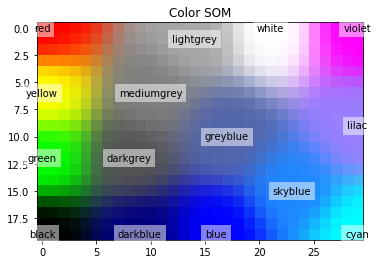

In [10]:
#Training inputs for RGBcolors
# colors = np.array(
#      [[0., 0., 0.],
#       [0., 0., 1.],
#       [0., 0., 0.5],
#       [0.125, 0.529, 1.0],
#       [0.33, 0.4, 0.67],
#       [0.6, 0.5, 1.0],
#       [0., 1., 0.],
#       [1., 0., 0.],
#       [0., 1., 1.],
#       [1., 0., 1.],
#       [1., 1., 0.],
#       [1., 1., 1.],
#       [.33, .33, .33],
#       [.5, .5, .5],
#       [.66, .66, .66]])
# color_names = \
#     ['black', 'blue', 'darkblue', 'skyblue',
#      'greyblue', 'lilac', 'green', 'red',
#      'cyan', 'violet', 'yellow', 'white',
#      'darkgrey', 'mediumgrey', 'lightgrey']
 
# #Train a 20x30 SOM with 400 iterations
# som = SOM(20, 30, 3, 400)
# som.train(colors)
 
# #Get output grid
# image_grid = som.get_centroids()
 
# #Map colours to their closest neurons
# mapped = som.map_vects(colors)
 
# #Plot
# plt.imshow(image_grid)
# plt.title('Color SOM')
# for i, m in enumerate(mapped):
#     plt.text(m[1], m[0], color_names[i], ha='center', va='center',
#              bbox=dict(facecolor='white', alpha=0.5, lw=0))
# plt.show()

##############################################################
# Training inputs for images z
train_images_1_z = np.load('model/train_images_1_z.npy')
 
# Train a 40x40 SOM with 10 iterations
som = SOM(40, 40, 640, 10)
som.train(train_images_1_z)
 
## Get output grid
som_weight_grid = som.get_centroids()
som_weight_grid = np.asarray(som_weight_grid)
print('som_weight_grid:', som_weight_grid.shape)
np.save('model/som_weight_grid.npy', som_weight_grid) 

## Map colours to their closest neurons
# mapped = som.map_vects(colors)

In [2]:
# %%
# load training image_1, training cmd_1, and training images_1_z
train_images_1 = np.load('train_images.npy')
train_cmds_1 = np.load("train_cmds.npy")
train_steps_1 = train_cmds_1[:, 0]
train_angles_1 = train_cmds_1[:, 1]
train_images_1_z = np.load('model/train_images_1_z.npy')
print(train_images_1.shape, train_cmds_1.shape, train_steps_1.shape, train_angles_1.shape, train_images_1_z.shape)

# load training image_2, training cmd_2, and and training images_2_z
# train_images_2 = np.load('train_images2.npy')
# train_cmds_2 = np.load("train_cmds2.npy")
# train_steps_2 = train_cmds_2[:, 0]
# train_angles_2 = train_cmds_2[:, 1]
# train_images_2_z = np.load('model/train_images_2_z.npy')
# print(train_images_2.shape, train_cmds_2.shape, train_steps_2.shape, train_angles_2.shape, train_images_2_z.shape)

# load test images, related commands and test images_z
test_images = np.load('test_images.npy')
test_cmds = np.load('test_cmds.npy')
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
test_images_z = np.load('model/test_images_z.npy')
print(test_images.shape, test_cmds.shape, test_xs.shape, len(test_x_set), test_ys.shape, len(test_y_set),
      test_angles.shape, len(test_angle_set), test_images_z.shape)
# print(test_x_set, test_y_set, test_angle_set)

(40000, 40, 320, 1) (39999, 3) (39999,) (39999,) (40000, 640)
(12096, 40, 320, 1) (12096, 3) (12096,) 24 (12096,) 14 (12096,) 36 (12096, 640)


(array([   10.,    64.,   177.,   279.,   364.,   553.,   694.,   755.,
          764.,   914.,   986.,   944.,  1022.,  1083.,  1133.,  1139.,
         1110.,  1039.,  1021.,   867.,   834.,   908.,   900.,   783.,
          703.,   650.,   643.,   700.,   644.,   626.,   624.,   653.,
          621.,   502.,   366.,   355.,   336.,   277.,   220.,   205.,
          202.,   200.,   226.,   194.,   123.,   110.,    77.,    77.,
           37.,    27.,    20.,     8.,     5.,     2.]),
 array([  50.61443177,   54.40320894,   58.19198611,   61.98076328,
          65.76954045,   69.55831762,   73.34709479,   77.13587196,
          80.92464913,   84.71342631,   88.50220348,   92.29098065,
          96.07975782,   99.86853499,  103.65731216,  107.44608933,
         111.2348665 ,  115.02364367,  118.81242084,  122.60119801,
         126.38997519,  130.17875236,  133.96752953,  137.7563067 ,
         141.54508387,  145.33386104,  149.12263821,  152.91141538,
         156.70019255,  160.488969

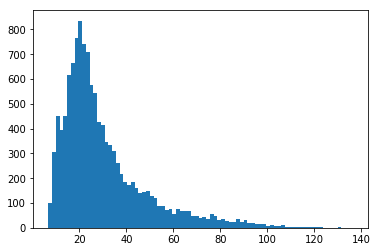

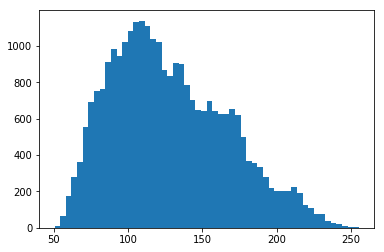

In [3]:
step_scores = []
angle_scores = []
for idx in range(train_images_1_z.shape[0]-1):
    train_image_z_1 =  train_images_1_z[idx, :]
    train_image_z_2 =  train_images_1_z[idx+1, :]
    train_step = train_steps_1[idx]
    train_angle = train_angles_1[idx]
    score = np.sum(np.power(np.subtract(train_image_z_1, train_image_z_2), 2))
    if train_step != 0:
        step_scores.append(score)
    if train_angle != 0:
        angle_scores.append(score)
        
plt.figure()
plt.hist(step_scores, bins='auto')
plt.figure()
plt.hist(angle_scores, bins='auto')

In [13]:
def find_match_list(image_list_z, max_idx, mini_score, max_score, find_image_z):
    end_idx = min(image_list_z.shape[0], max_idx)
    match_idx_list = []
    for idx in range(end_idx):
        score = np.sum(np.power(np.subtract(image_list_z[idx, :], find_image_z), 2))
        if score >= mini_score and score <= max_score:
            match_idx_list.append(idx)
    return match_idx_list

cell_list = [i for i in range(train_images_1_z.shape[0])]
head_cell_uf = UnionFind(cell_list)
place_cell_uf = UnionFind(cell_list)

for idx in range(train_images_1_z.shape[0]):
    if idx % 800 == 0:
        print(datetime.datetime.now().time(), ':', idx, ':head_cell', len(head_cell_uf.components()),
              'place_cell', len(place_cell_uf.components()))
    if idx != 0:
        train_step = train_steps_1[idx-1]
        train_angle = train_angles_1[idx-1]
        find_image_z = train_images_1_z[idx]
        if train_angle != 0:
            # find a list of match head direction cell
            best_match_list = find_match_list(train_images_1_z, idx, 0.0, 40.0, find_image_z)
            if len(best_match_list) != 0:
                for best_match_idx in best_match_list:
                    head_cell_uf.union(idx, best_match_idx)
            # set the place cell the same as the previous image
            place_cell_uf.union(idx, idx-1)
        elif train_step != 0:
            # find a list of match place cell
            best_match_list = find_match_list(train_images_1_z, idx, 0, 40.0, find_image_z)
            if len(best_match_list) != 0:
                for best_match_idx in best_match_list:
                    place_cell_uf.union(idx, best_match_idx)
            # set the head direction cell the same as the previous image
            head_cell_uf.union(idx, idx-1)
        else:
            print('ERROR!!!')
            
print('head_cell', len(head_cell_uf.components()), 'place_cell', len(place_cell_uf.components()))

16:08:14.466430 : 0 :head_cell 40000 place_cell 40000
16:08:27.014587 : 800 :head_cell 39537 place_cell 39409
16:08:56.080637 : 1600 :head_cell 39018 place_cell 38814
16:09:41.403552 : 2400 :head_cell 38385 place_cell 38163
16:10:48.569587 : 3200 :head_cell 37703 place_cell 37510
16:12:16.767080 : 4000 :head_cell 36917 place_cell 36862
16:14:10.135354 : 4800 :head_cell 36156 place_cell 36198
16:16:15.726320 : 5600 :head_cell 35347 place_cell 35540
16:18:43.360792 : 6400 :head_cell 34510 place_cell 34811
16:21:26.277393 : 7200 :head_cell 33650 place_cell 34097
16:24:33.399593 : 8000 :head_cell 32849 place_cell 33416
16:27:57.169517 : 8800 :head_cell 32054 place_cell 32709
16:31:27.707761 : 9600 :head_cell 31261 place_cell 32020
16:35:32.651883 : 10400 :head_cell 30441 place_cell 31277
16:39:49.634285 : 11200 :head_cell 29617 place_cell 30592
16:44:57.712714 : 12000 :head_cell 28802 place_cell 29919
16:50:08.896786 : 12800 :head_cell 27992 place_cell 29203
16:55:51.092341 : 13600 :head_c

NameError: name 'head_cell_counter' is not defined

In [18]:
head_image_map = head_cell_uf.components()
head_cell_size = len(head_image_map)
image_head_map = np.zeros(train_images_1_z.shape[0])
head_cell_counter = 0
for image_list in head_image_map:
    for image_idx in image_list:
        image_head_map[image_idx] = head_cell_counter
    head_cell_counter += 1
print(head_cell_counter, 'head_cell_size:', head_cell_size)
    
place_image_map = place_cell_uf.components()
place_cell_size = len(place_image_map)
image_place_map = np.zeros(train_images_1_z.shape[0])
place_cell_counter = 0
for image_list in place_image_map:
    for image_idx in image_list:
        image_place_map[image_idx] = place_cell_counter
    place_cell_counter += 1
print(place_cell_counter, 'place_cell_size:', place_cell_size)

200 head_cell_size: 200
3064 place_cell_size: 3064


In [22]:
print(test_images_z.shape, train_images_1_z.shape)
head_cell_test_out = np.zeros((test_images_z.shape[0], head_cell_size))
place_cell_test_out = np.zeros((test_images_z.shape[0], place_cell_size))
print(head_cell_test_out.shape, place_cell_test_out.shape)

for test_image_z_idx in range(test_images_z.shape[0]):
    
    test_image_z = test_images_z[test_image_z_idx, :]
    image_dist_tmp = np.sum(np.power((train_images_1_z - test_image_z), 2), 1)
    mini_idx = np.argmin(image_dist_tmp)
    
    head_cell_idx = image_head_map[mini_idx]
#     print(mini_idx, head_cell_idx)
    head_cell_test_out[test_image_z_idx, int(head_cell_idx)] = 1
    
    place_cell_idx = image_place_map[mini_idx]
    place_cell_test_out[test_image_z_idx, int(place_cell_idx)] = 1
    
    if test_image_z_idx % 200 == 0:
        print(datetime.datetime.now().time(), ':', test_image_z_idx,
              'head_cell_idx:', head_cell_idx, 'place_cell_idx:', place_cell_idx)

(12096, 640) (40000, 640)
(12096, 200) (12096, 3064)
23:44:30.016943 : 0 head_cell_idx: 111.0 place_cell_idx: 110.0
23:47:52.369710 : 200 head_cell_idx: 98.0 place_cell_idx: 1006.0
23:51:18.420875 : 400 head_cell_idx: 174.0 place_cell_idx: 1275.0
23:54:46.216517 : 600 head_cell_idx: 93.0 place_cell_idx: 2688.0
23:58:22.829541 : 800 head_cell_idx: 161.0 place_cell_idx: 1664.0
00:01:59.674531 : 1000 head_cell_idx: 70.0 place_cell_idx: 2229.0
00:05:17.092256 : 1200 head_cell_idx: 46.0 place_cell_idx: 13.0
00:08:38.542269 : 1400 head_cell_idx: 146.0 place_cell_idx: 1354.0
00:12:14.322993 : 1600 head_cell_idx: 169.0 place_cell_idx: 1747.0
00:15:58.785185 : 1800 head_cell_idx: 111.0 place_cell_idx: 1196.0
00:19:42.001949 : 2000 head_cell_idx: 98.0 place_cell_idx: 1563.0
00:23:14.084373 : 2200 head_cell_idx: 42.0 place_cell_idx: 2755.0
00:26:41.985522 : 2400 head_cell_idx: 93.0 place_cell_idx: 2169.0
00:30:07.898768 : 2600 head_cell_idx: 36.0 place_cell_idx: 110.0
00:33:33.234071 : 2800 head_

In [24]:
f = open('model/image_head_map.pickle', 'wb')
pickle.dump(image_head_map, f, pickle.HIGHEST_PROTOCOL)
f = open('model/image_place_map.pickle', 'wb')
pickle.dump(image_place_map, f, pickle.HIGHEST_PROTOCOL)

np.save('model/head_cell_test_out.npy', head_cell_test_out)
np.save('model/place_cell_test_out.npy', place_cell_test_out)

In [26]:
head_map_4_head_cell = np.zeros((36, head_cell_size))
place_map_4_head_cell = np.zeros((14, 24, head_cell_size))
head_map_4_place_cell = np.zeros((36, place_cell_size))
place_map_4_place_cell = np.zeros((14, 24, place_cell_size))

for test_image_z_idx in range(test_images_z.shape[0]):
    test_x = test_xs[test_image_z_idx]
    test_y = test_ys[test_image_z_idx]
    test_angle = test_angles[test_image_z_idx]
    head_map_4_head_cell[test_angle.astype(int), :] += head_cell_test_out[test_image_z_idx, :]
    place_map_4_head_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += head_cell_test_out[test_image_z_idx, :]
    head_map_4_place_cell[test_angle.astype(int), :] += place_cell_test_out[test_image_z_idx, :]
    place_map_4_place_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += place_cell_test_out[test_image_z_idx, :]

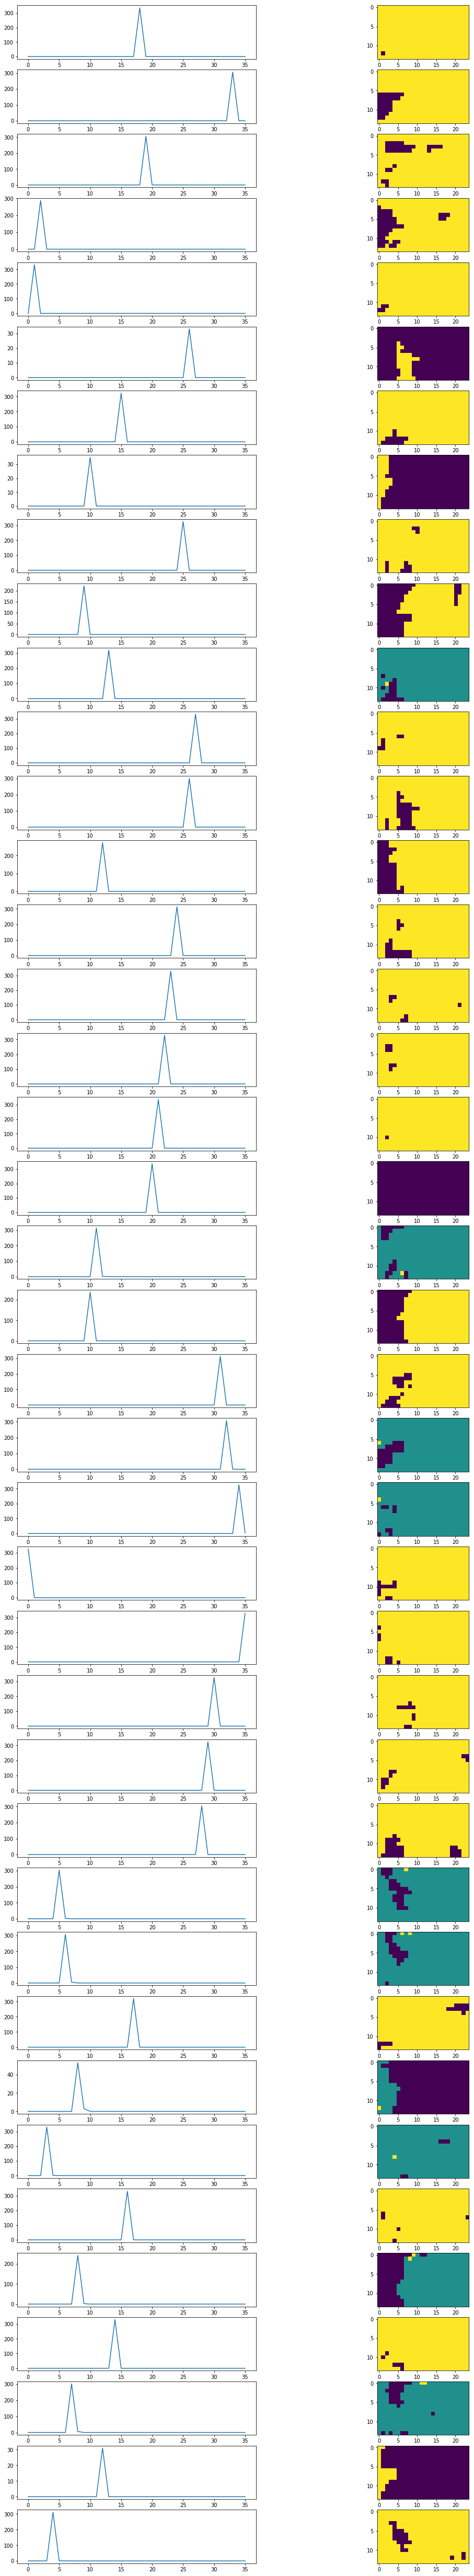

In [41]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
idx_counter = 0
for head_cell_idx in range(head_cell_size):
    if np.max(head_map_4_head_cell[:, head_cell_idx]) >= 30 and idx_counter < 40:
        axs[idx_counter][0].plot(np.abs(head_map_4_head_cell[:, head_cell_idx]))
    #     axs[idx_counter][0].set_ylim(0, 20)
        axs[idx_counter][1].imshow(np.abs(place_map_4_head_cell[:, :, head_cell_idx]))
        idx_counter += 1
plt.show()

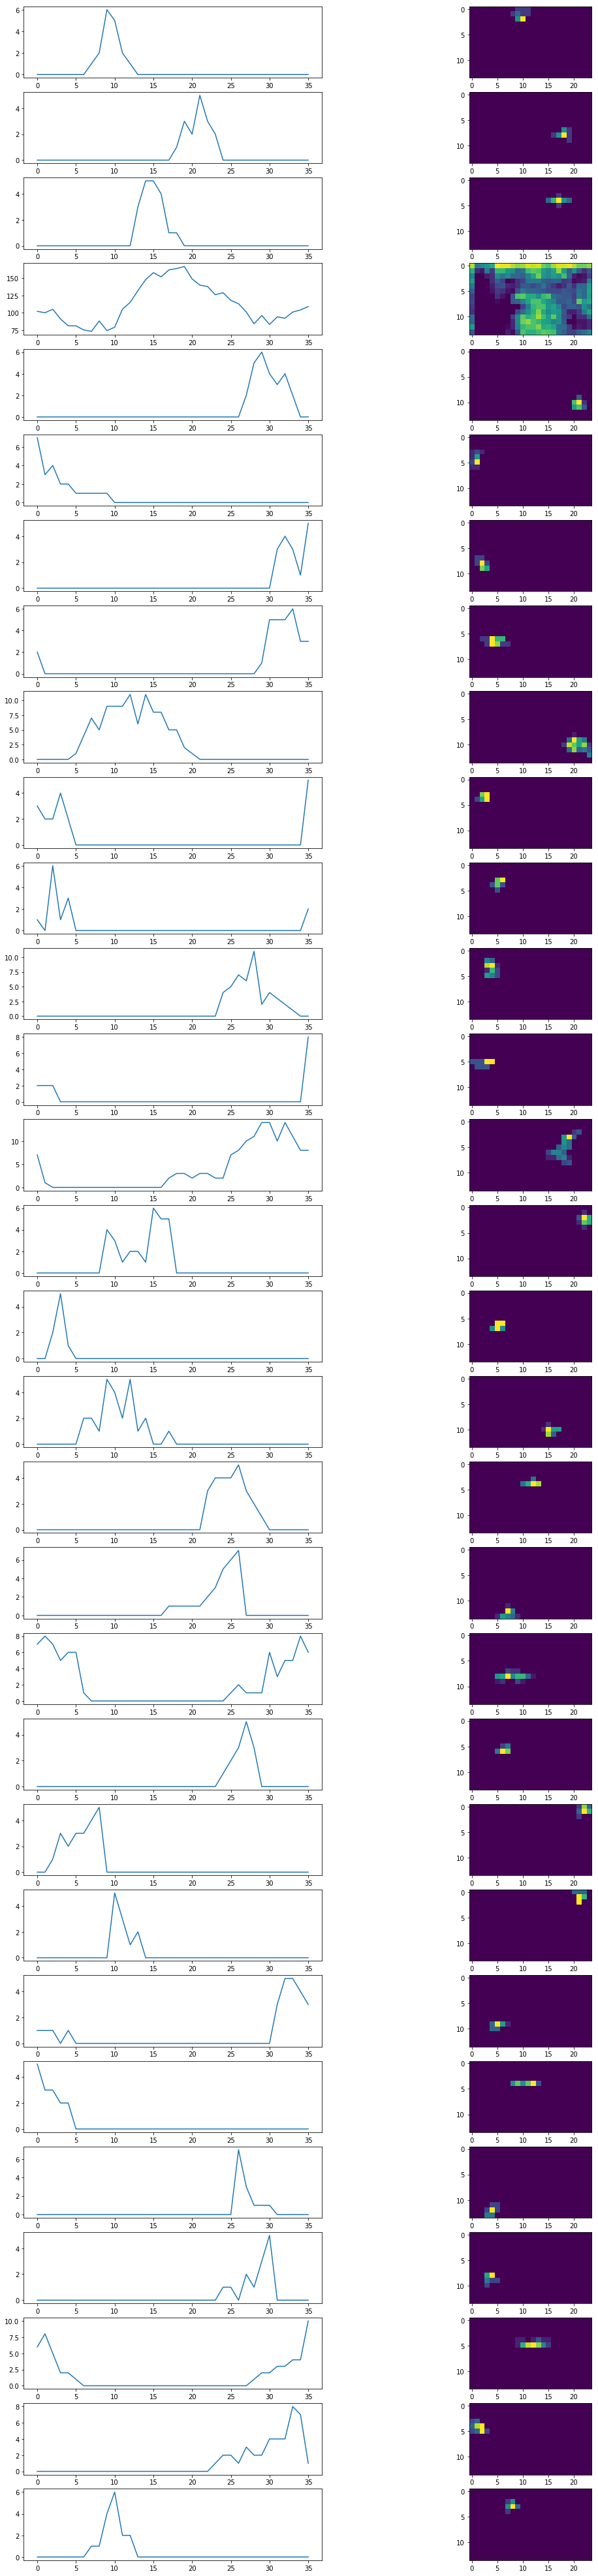

In [34]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
idx_counter = 0
for place_cell_idx in range(place_cell_size):
    if np.max(head_map_4_place_cell[:, place_cell_idx]) >= 5 and idx_counter < 30:
        axs[idx_counter][0].plot(np.abs(head_map_4_place_cell[:, place_cell_idx]))
    #     axs[idx_counter][0].set_ylim(0, 20)
        axs[idx_counter][1].imshow(np.abs(place_map_4_place_cell[:, :, place_cell_idx]))
        idx_counter += 1
plt.show()